# DeepLearning approach code implementation

For packages installation in a google colab environment only open3d is necessary to install. Otherwise, all the below packages are required to run this notebook.

In [ ]:
# !pip install open3d torch torchvision matplotlib pandas tqdm opencv-contrib-python tqdm numpy plotly
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.1
    Unin

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-jilr1y9w
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-jilr1y9w
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp311-cp311-linux_x86_64.whl size=60241966 sha256=91d7b2ef810511edd7544f63d963c9d28e4f31716a2fda203622017558eda7e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-b9yn7ju5/wheels/08/90/1b/df18c3e3634f86278e793b87f37ea4c58d0c36731196122518
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=d8e8668187d48478cfffaf5

In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm
import cv2
import open3d as o3d

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    PerspectiveCameras,
    AmbientLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

Before importing the images, please follow the directory structure required to properly import all the relevant information.
On the `data` directory please create 2 folders: `imgs` for saving the RGB images and `silhouettes` for saving the respective silhouette of the target RGB image. In addition, please save the camera parameters into a file named `calibration.csv`.

In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = './data'
camera_parameters = pd.read_csv(os.path.join(DATA_DIR, 'calibration.csv'))
imgs_paths = os.listdir(os.path.join(DATA_DIR, 'imgs'))
silhouettes_paths = os.listdir(os.path.join(DATA_DIR, 'silhouettes'))
imgs_paths.sort()
silhouettes_paths.sort()
if '.ipynb_checkpoints' in imgs_paths:
  imgs_paths.pop(0)


In [ ]:
# Camera parameters for each camera
cameras = []
img_size = (int(camera_parameters['h'].iloc[0]), int(camera_parameters['w'].iloc[0]))
for i in range(len(imgs_paths)):
  name = imgs_paths[i].split('_')[0]
  # print('Images' + name + ' ' + camera_parameters['name'].iloc[i])
  if name != camera_parameters['name'].iloc[i]:
    print('Image mismatch ' + name + ' ' + camera_parameters['name'].iloc[i])
    break
  Rvec = np.array([camera_parameters['rx'].iloc[i], camera_parameters['ry'].iloc[i], camera_parameters['rz'].iloc[i]])
  Rmat = cv2.Rodrigues(Rvec)[0]
  Tvec = np.array([[camera_parameters['tx'].iloc[i], camera_parameters['ty'].iloc[i], camera_parameters['tz'].iloc[i]]]) # For shape (1, 3)

  R = torch.from_numpy(np.array([Rmat])).to(device) # For shape (1, 3, 3)
  T = torch.from_numpy(Tvec).to(device)
  # K = torch.tensor([[
  #     [camera_parameters['fx'].iloc[i], 0, camera_parameters['px'].iloc[i], 0],
  #     [0, camera_parameters['fy'].iloc[i], camera_parameters['py'].iloc[i], 0],
  #     [0, 0, 0, 1],
  #     [0, 0, 1, 0]
  # ]])
  intrinsics = o3d.camera.PinholeCameraIntrinsic( o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault )
  Kmat = intrinsics.intrinsic_matrix
  cameras.append(PerspectiveCameras(
      device=device,
      R=R,
      T=T,
      image_size=(img_size,),
      # focal_length=[(camera_parameters['fx'].iloc[i], camera_parameters['fy'].iloc[i])],
      # principal_point=((camera_parameters['px'].iloc[i], camera_parameters['py'].iloc[i]),),
      focal_length=[(Kmat[0, 0], Kmat[1, 1])],
      principal_point=((Kmat[0, 2], Kmat[1, 2]),),
      in_ndc=False
      ))

camera = cameras[0] # Camera used for rendering the results


In [ ]:
# Loading images and transforming them to tensors
import cv2
from torchvision import transforms

def load_images(imgs_paths, DATA_DIR, silhouettes=True):
  transform = transforms.Compose([ transforms.ToTensor() ])
  target_imgs = []
  for i in range(len(imgs_paths)):
    if silhouettes:
      img = cv2.imread(os.path.join(DATA_DIR, 'silhouettes', imgs_paths[i]))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
      img = cv2.imread(os.path.join(DATA_DIR, 'imgs', imgs_paths[i]), cv2.IMREAD_COLOR_RGB)
    tensor = transform(img)
    target_imgs.append(tensor.to(device))
  return target_imgs


target_silouhettes = load_images(silhouettes_paths, DATA_DIR)
target_imgs = load_images(imgs_paths, DATA_DIR, False)

In [ ]:
# Concatenate the ensors together into a torch iterable object which will be used to iterate over the set of target images or silhouettes.
target_sillouhettes = torch.cat(target_silouhettes, dim=0)
print(target_sillouhettes.shape)

target_imgs = torch.cat(target_imgs, dim=0)
print(target_imgs.shape)

torch.Size([30, 1022, 747])
torch.Size([90, 1022, 747])


In [ ]:
# Rasterization settings for silhouette rendering
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size= img_size,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
    perspective_correct=False
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

In [ ]:
lights = AmbientLights(device=device)
# Rasterization settings for texture image rendering.
raster_settings = RasterizationSettings(
    image_size= img_size,
    blur_radius=0.0,
    faces_per_pixel=1,
    perspective_correct=False
)

# Texture renderer
renderer_imgs = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights
    )
)

## Helper functions for visualization

In [ ]:
# Show a visualization comparing the rendered predicted mesh to the ground truth
# mesh
def visualize_prediction(predicted_mesh, renderer,
                         target_image, title='',
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())
    plt.title(title)

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

## Starting Mesh

The starting mesh can be either an icosphere or an body mesh. To use any of them uncomment the respective line of code.

In [ ]:
# We initialize the source shape to be a sphere of radius 1.
# src_mesh = ico_sphere(4, device)

# Import body mesh
src_mesh = load_objs_as_meshes([os.path.join(DATA_DIR, 'BaseMesh.obj')]).to(device)

/usr/local/lib/python3.11/dist-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: ./data/BaseMesh.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [ ]:
import plotly.graph_objects as go

def plot_mesh(mesh):
    # Extract vertices and faces
    verts = mesh.verts_list()[0].cpu().numpy()
    faces = mesh.faces_list()[0].cpu().numpy()

    x, y, z = verts[:, 0], verts[:, 1], verts[:, 2]
    i, j, k = faces[:, 0], faces[:, 1], faces[:, 2]

    fig = go.Figure(data=[go.Mesh3d(
        x=x, y=y, z=z,
        i=i, j=j, k=k,
        color='lightblue', opacity=0.5
    )])
    fig.update_layout(scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ))
    fig.show()

plot_mesh(src_mesh)

## Renderer for rendering the silhouette and texture of our predicted mesh

In [ ]:
# Rasterization settings for differentiable rendering
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=img_size,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
    perspective_correct=False,
)


# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

# Texture renderer
# renderer_textured = MeshRenderer(
#   rasterizer=MeshRasterizer(
#       cameras=camera,
#       raster_settings=raster_settings_soft
#   ),
#   shader=SoftPhongShader(device=device,
#       cameras=camera,
#       lights=lights)
# )

Initialization of settings for the rendering losses

In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 6000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette and RBG image loss, mesh edge loss, mesh normal
# consistency, and mesh laplacian smoothing
losses = {#"rgb": {"weight": 1.0, "values": []},
          "silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# We will also learn per vertex colors for our sphere mesh that define texture
# of the mesh
# sphere_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
# optimizer_adam = torch.optim.Adam([deform_verts], lr=1.0)

## Training loop

In [ ]:
# In case of running this notebook on google colab, run this line of code to 
# avoid errors related to the display of the resulting comparisons between 
# the rendered image and the target image.
from google.colab import output
output.enable_custom_widget_manager()

  0%|          | 0/6000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch3d/ops/laplacian_matrices.py:51: UserWarning:

torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)

/tmp/ipython-input-16-3637215881.py:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



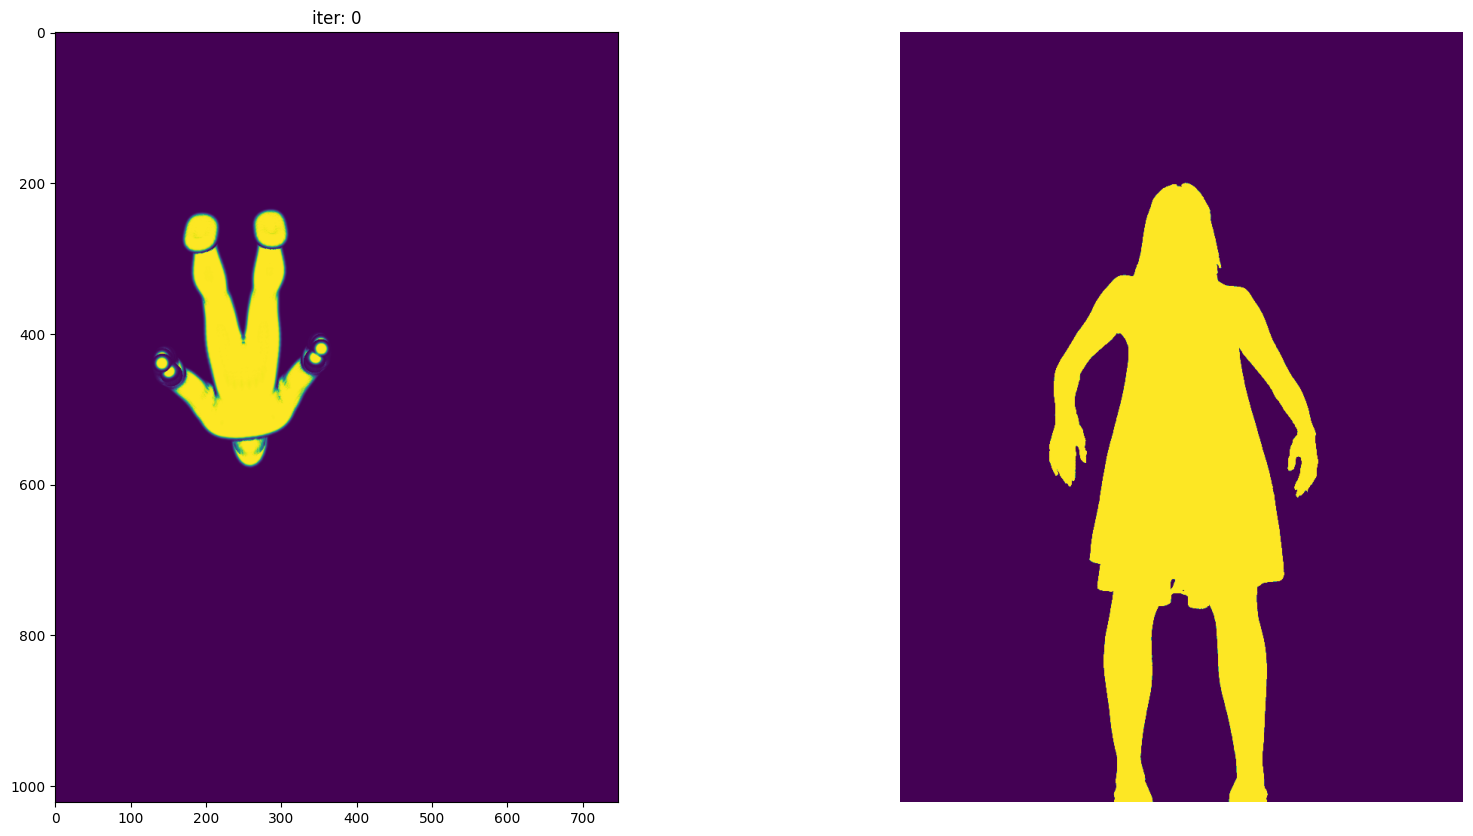

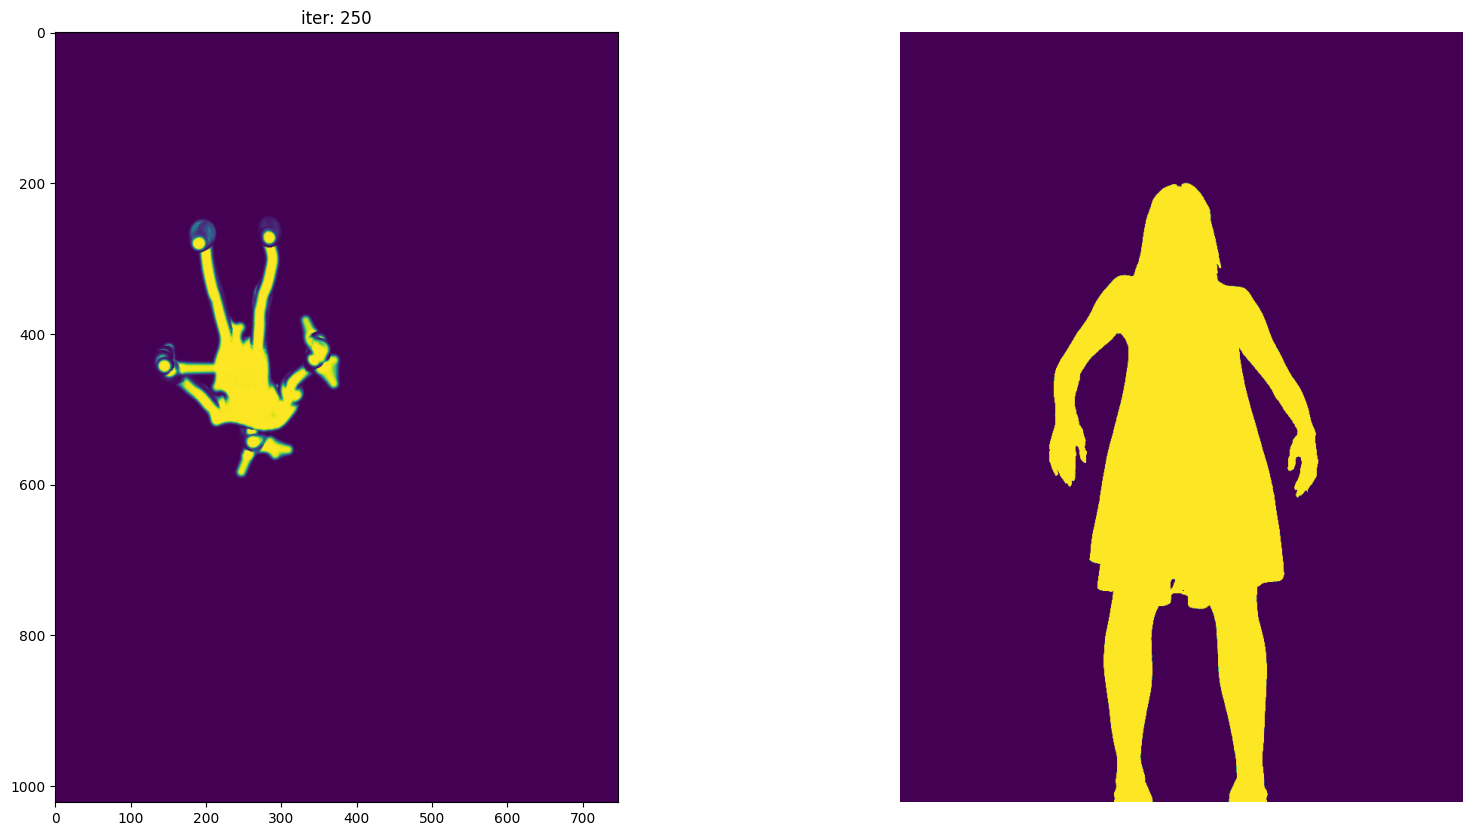

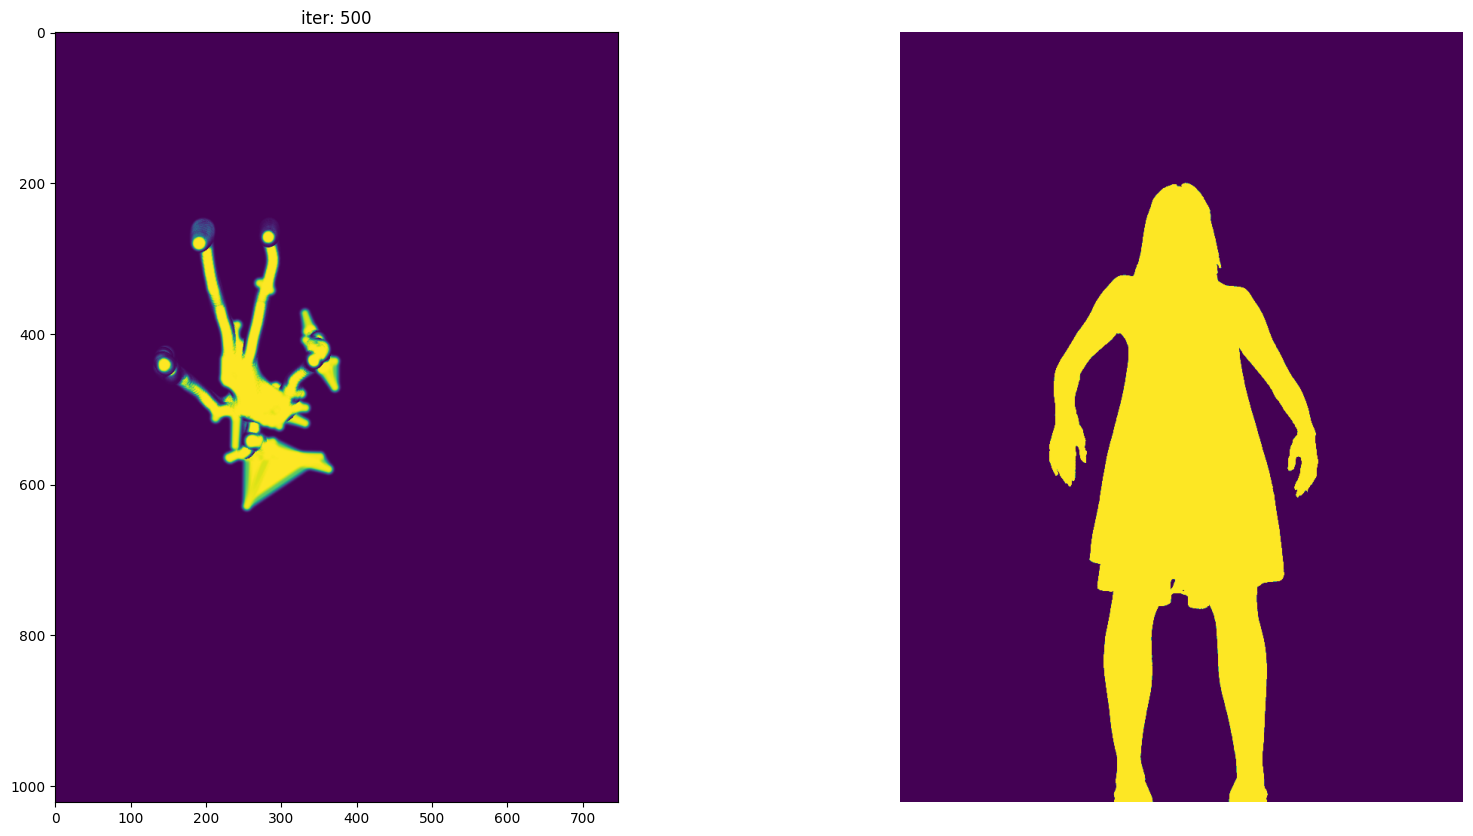

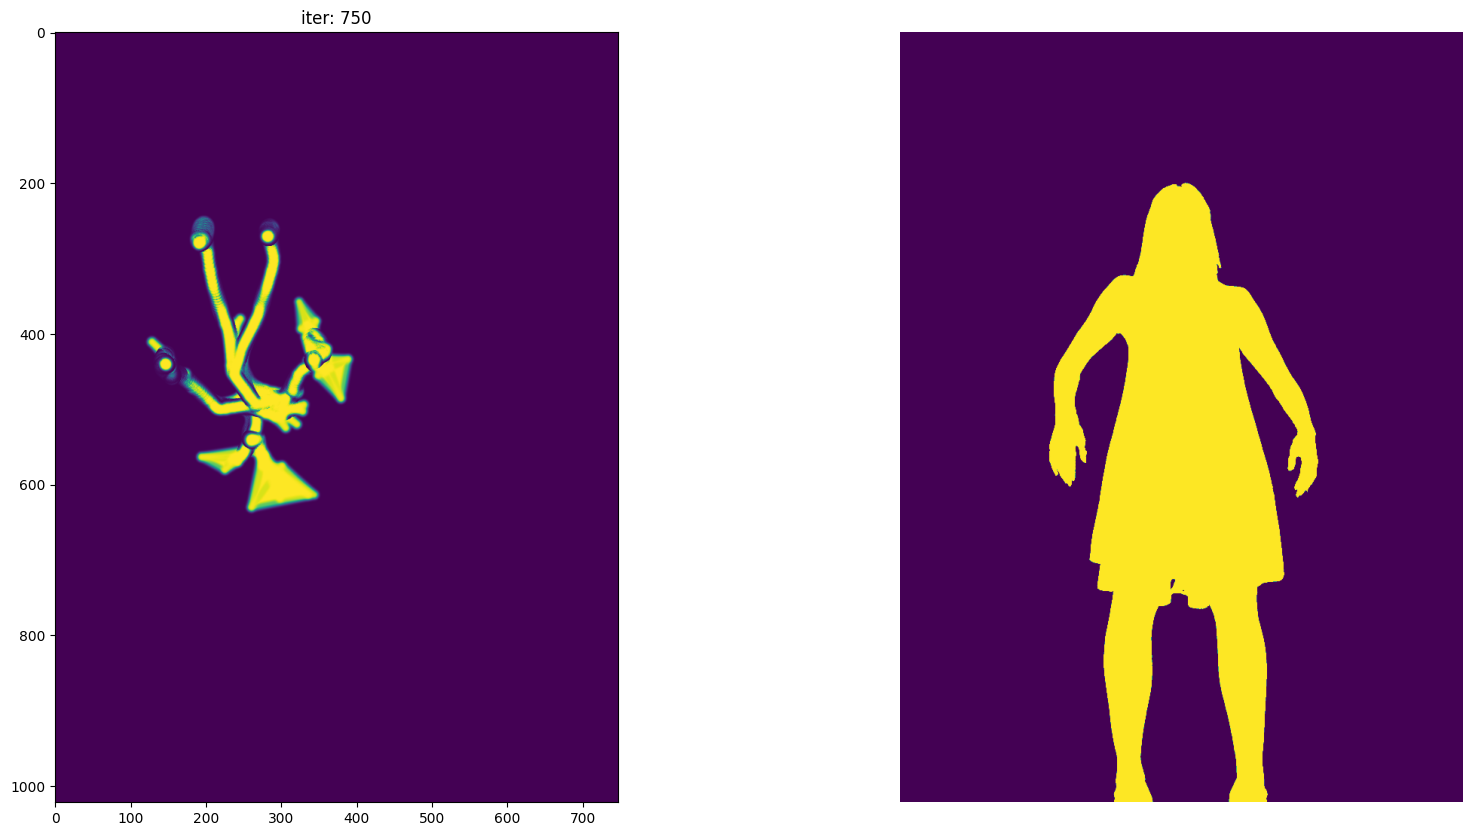

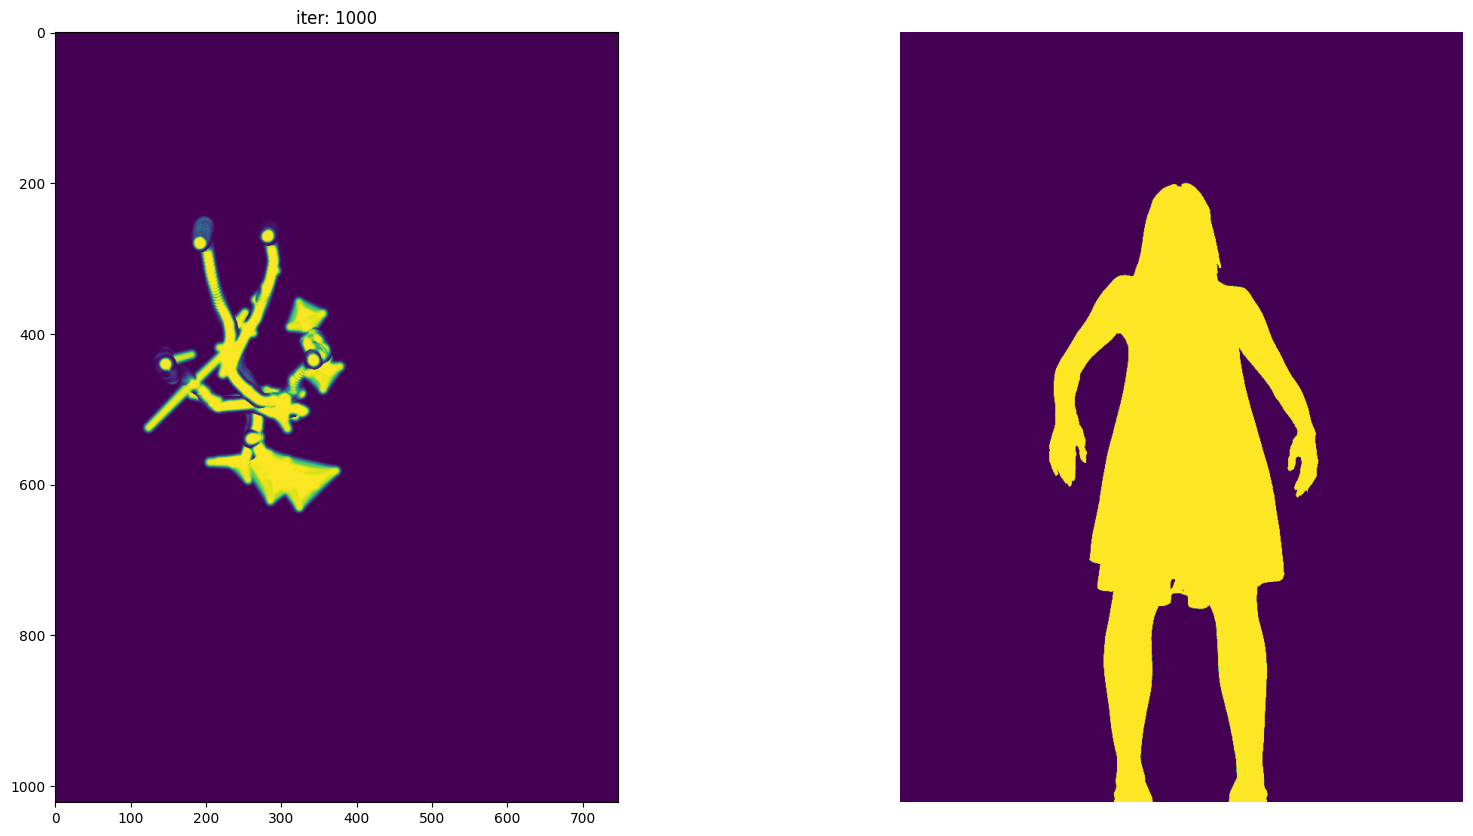

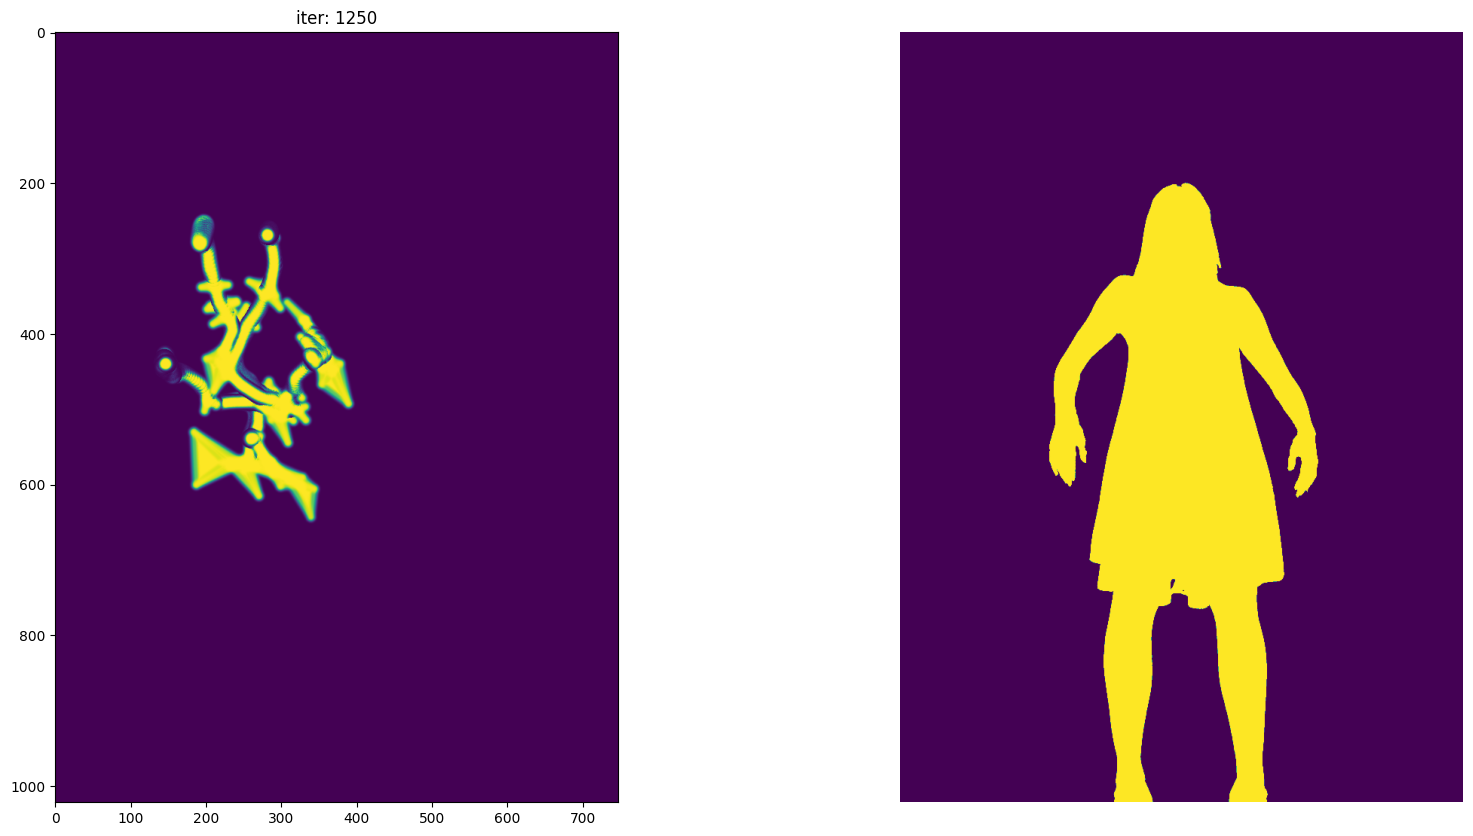

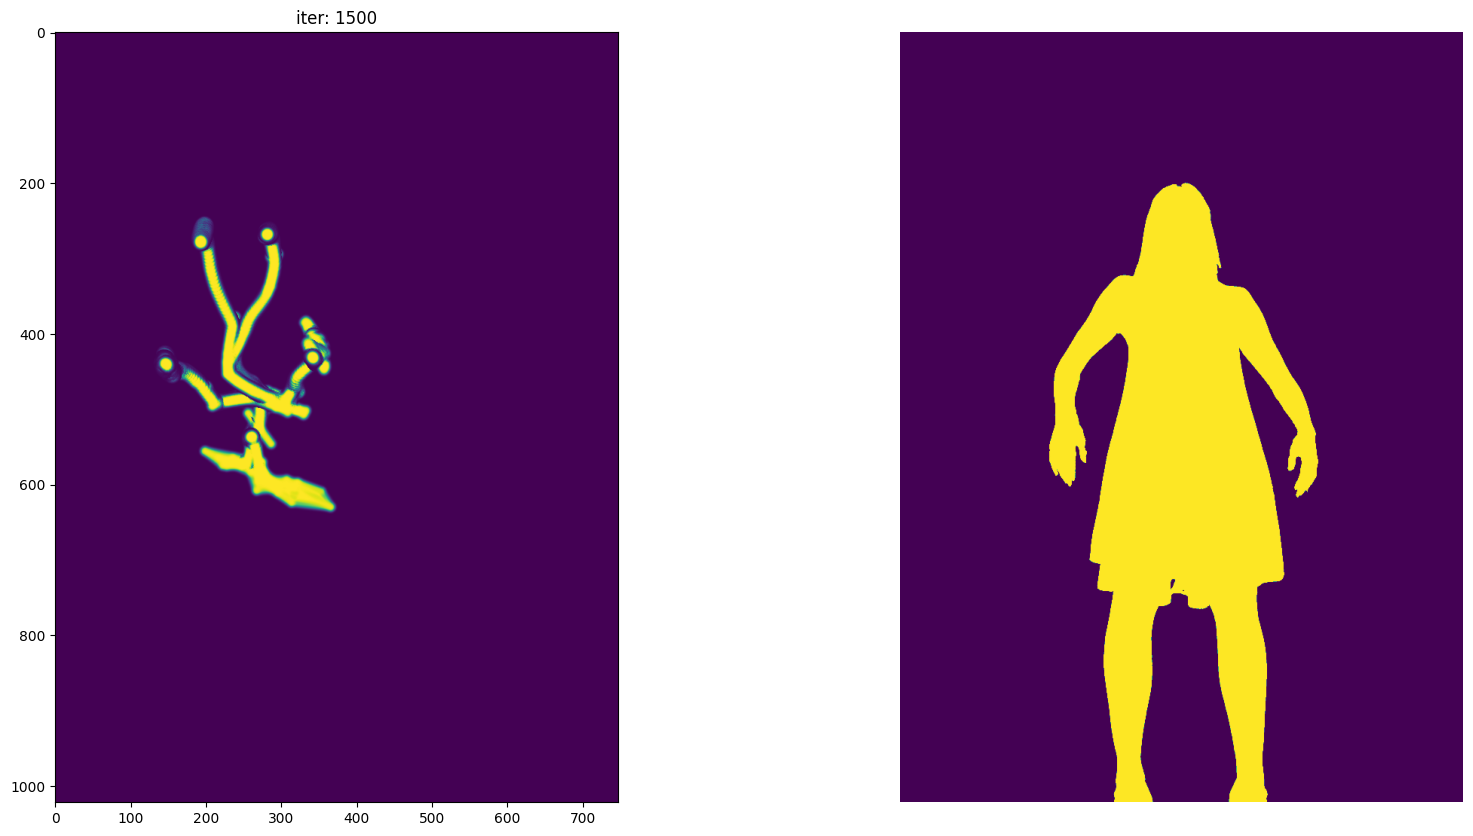

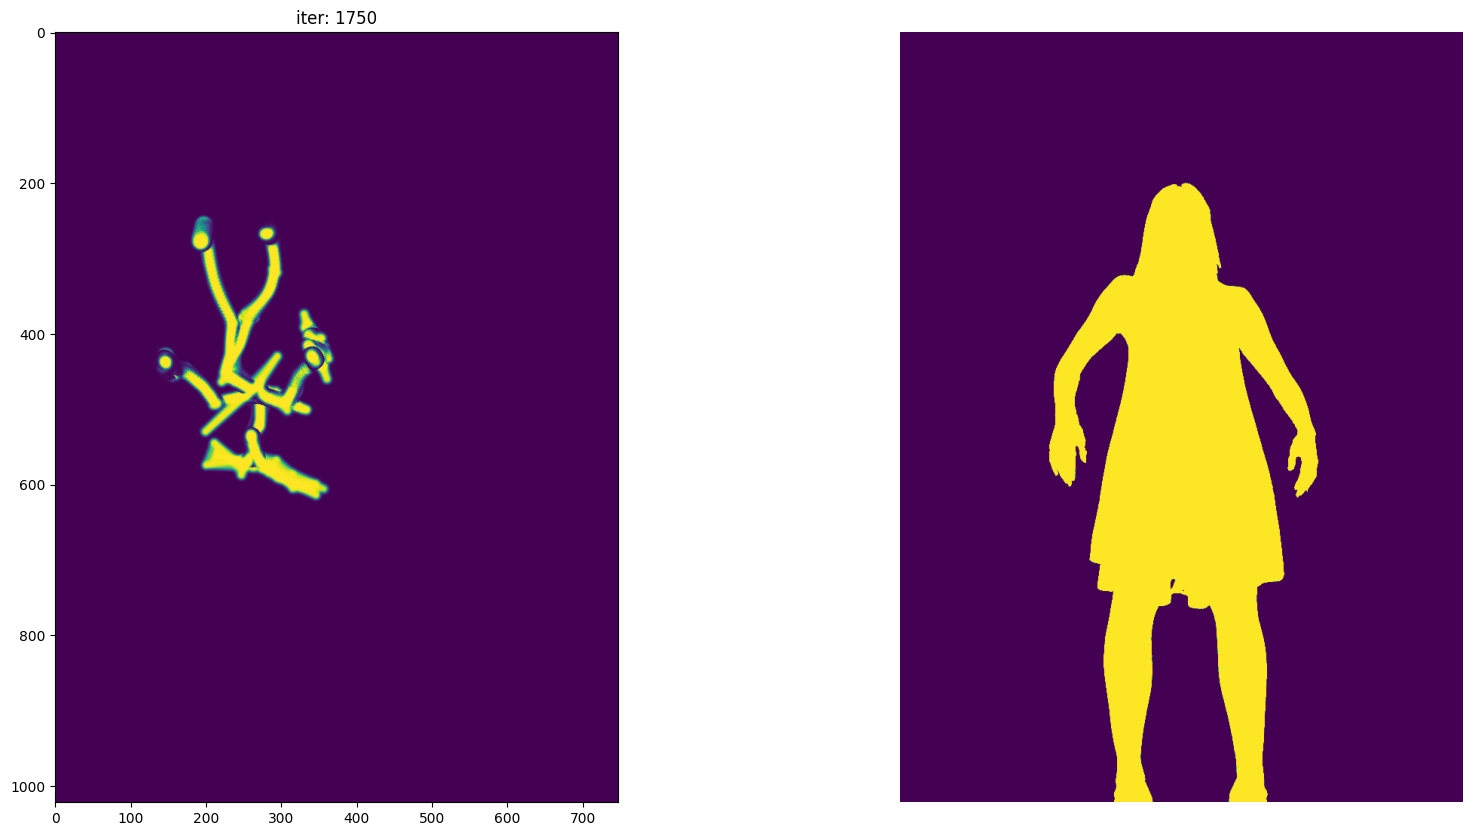

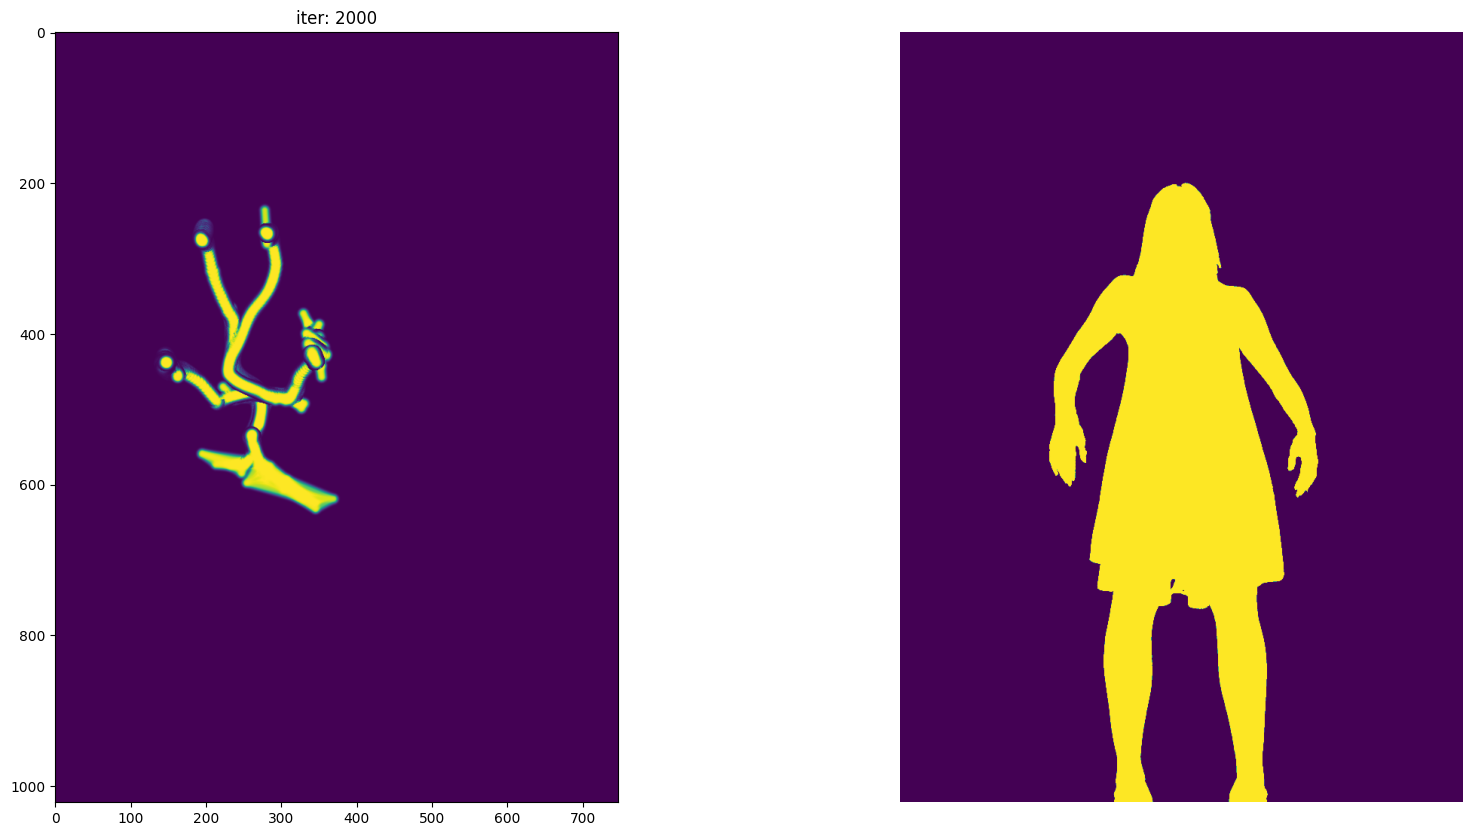

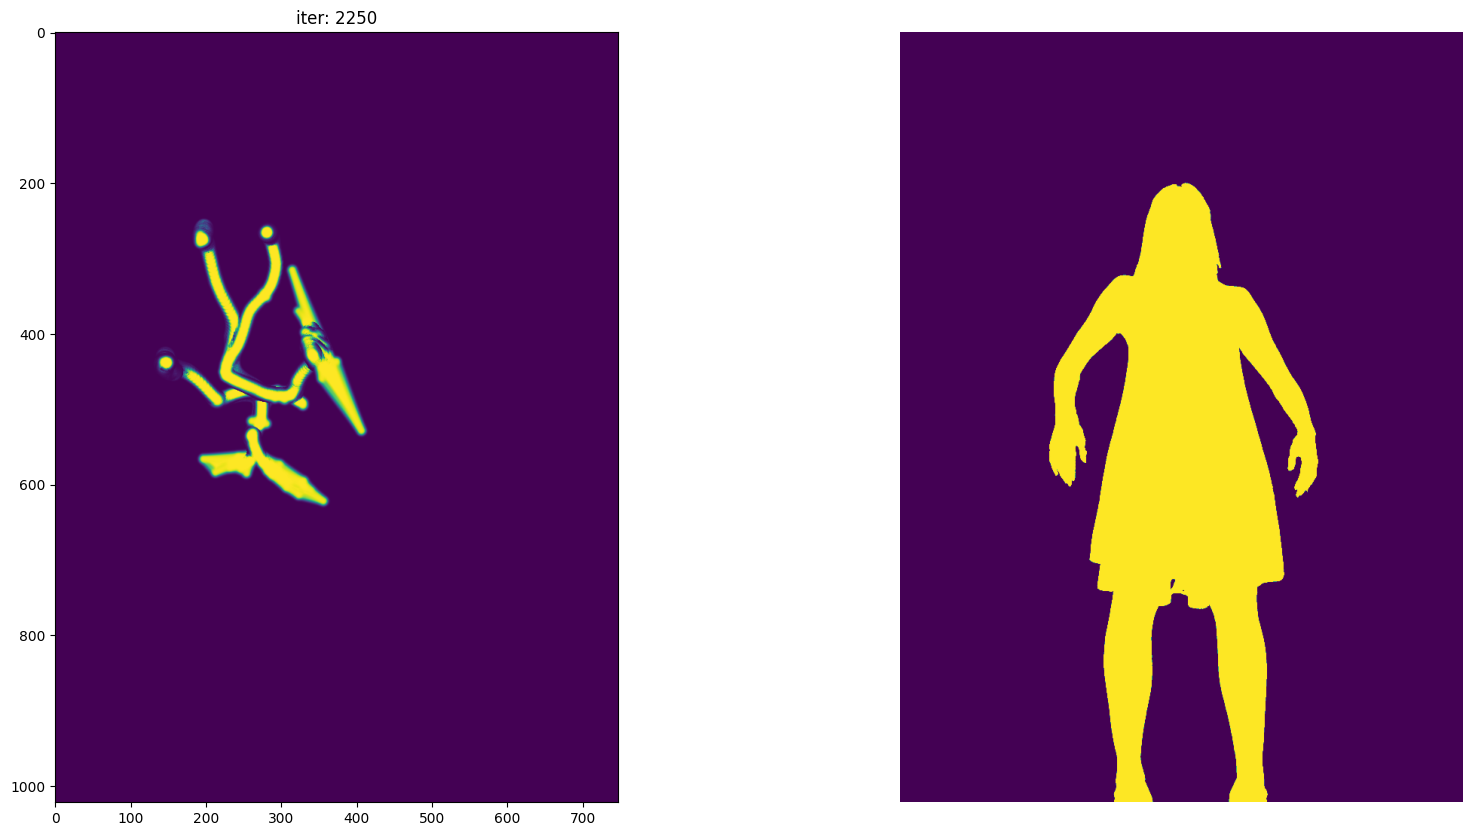

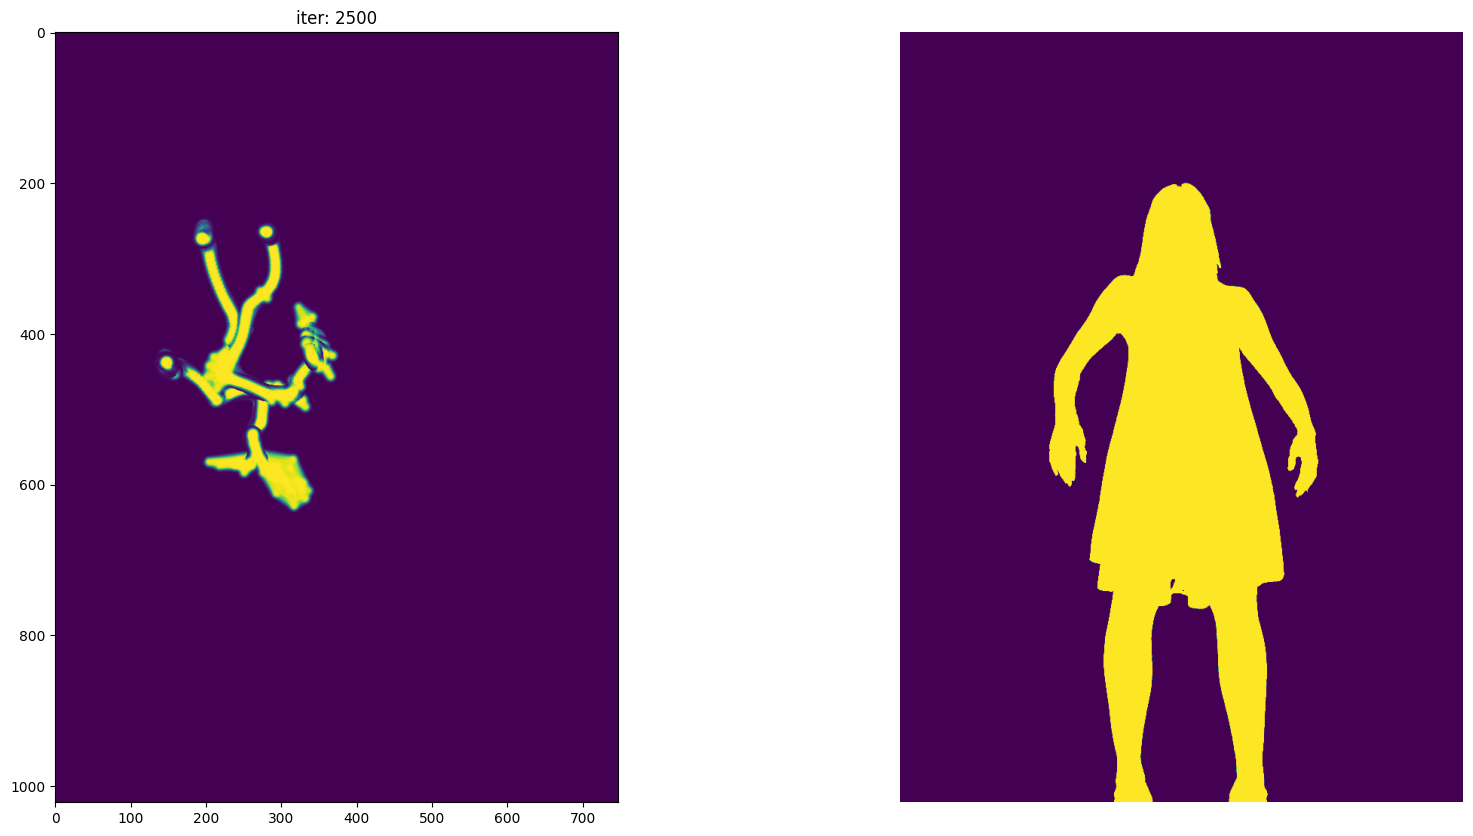

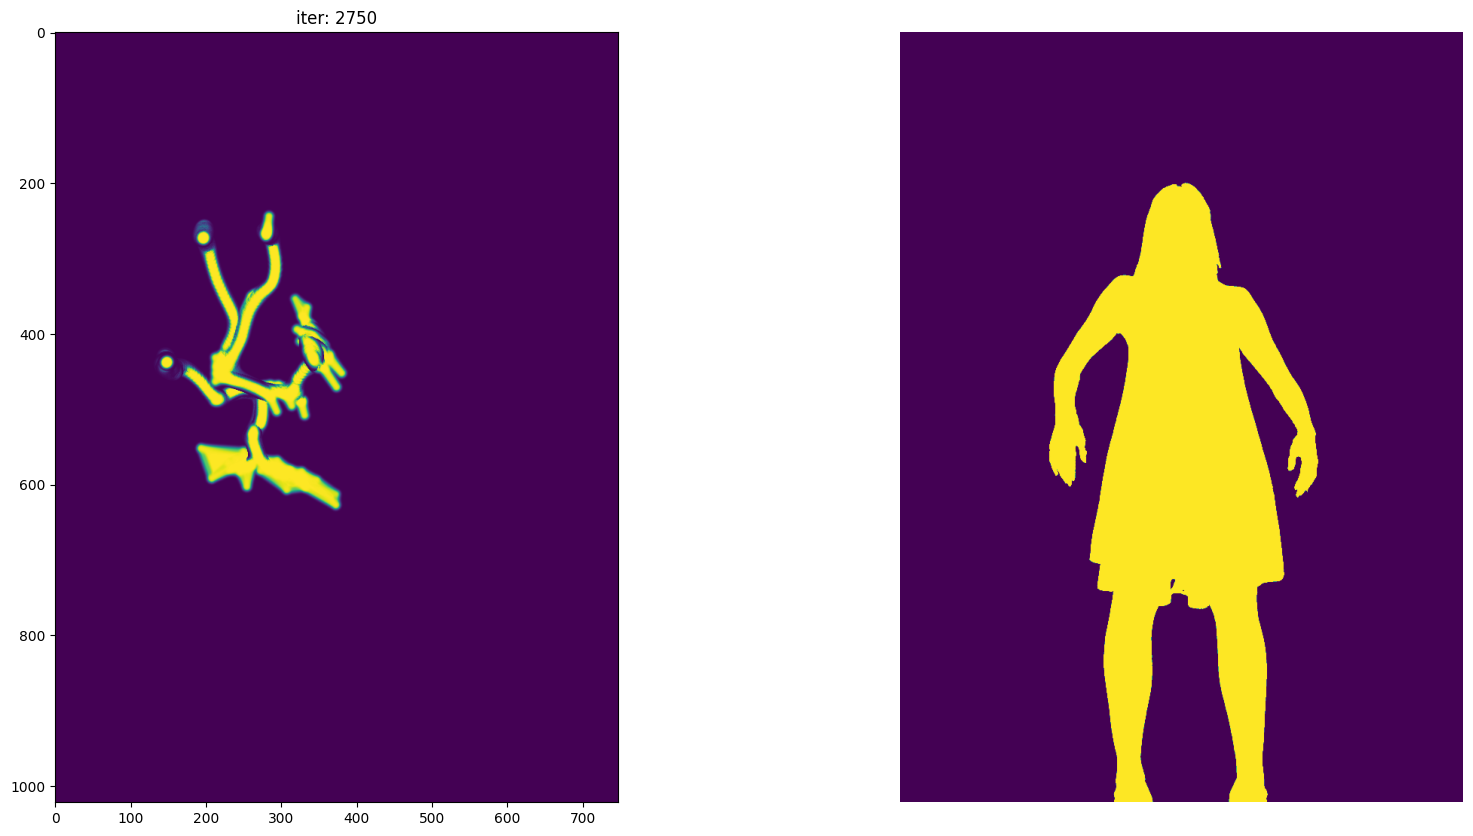

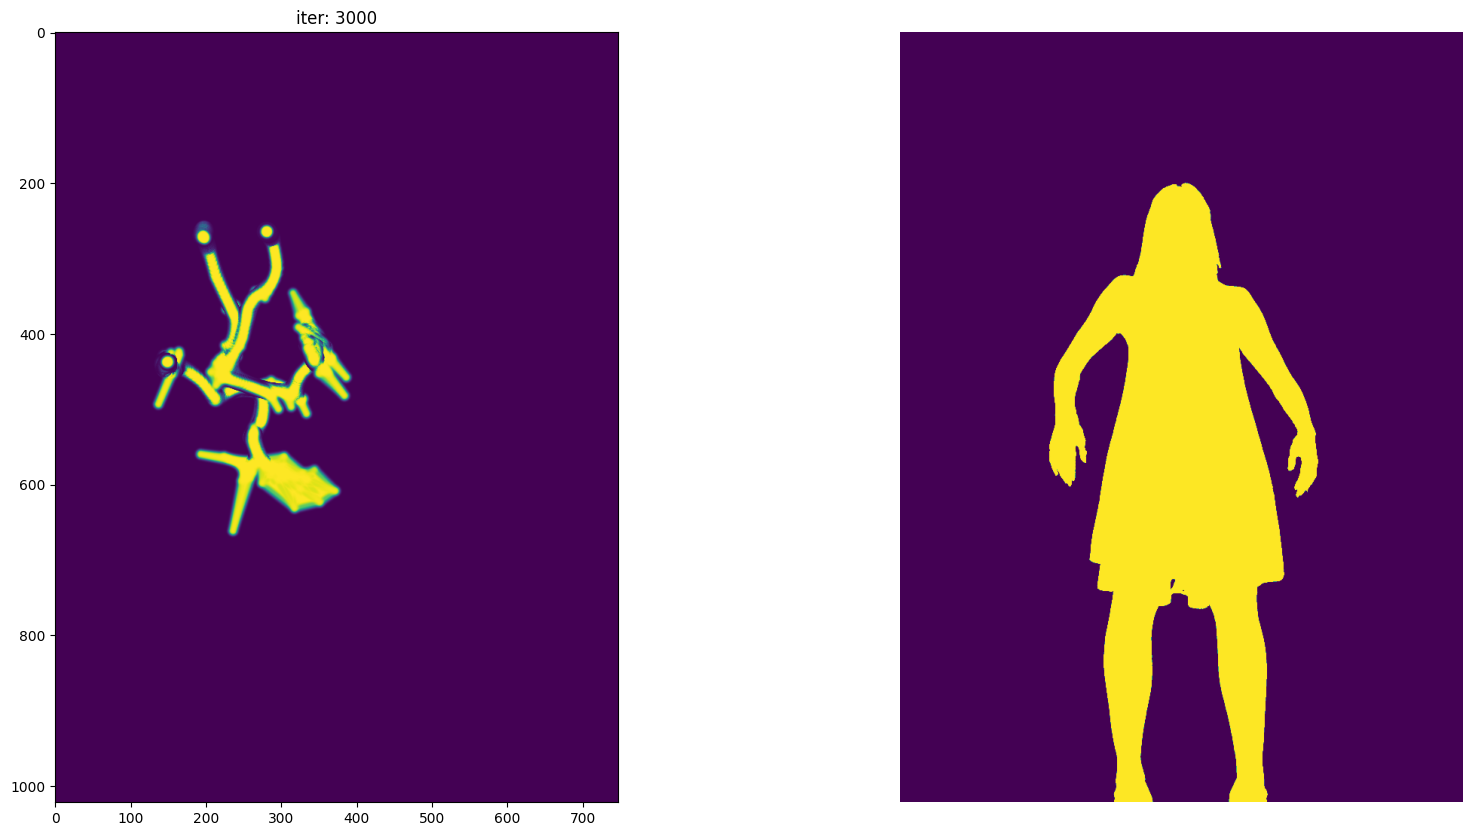

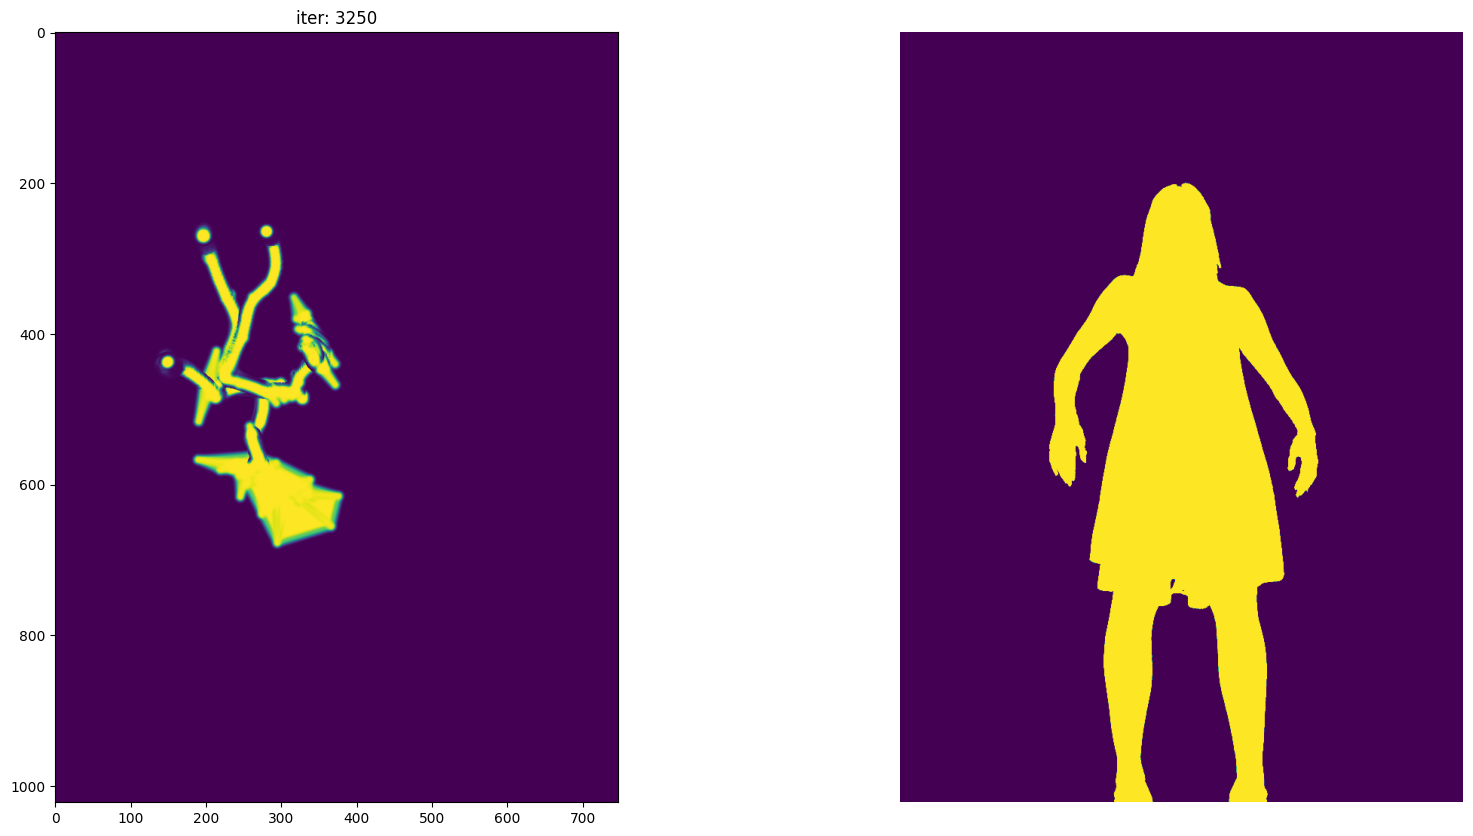

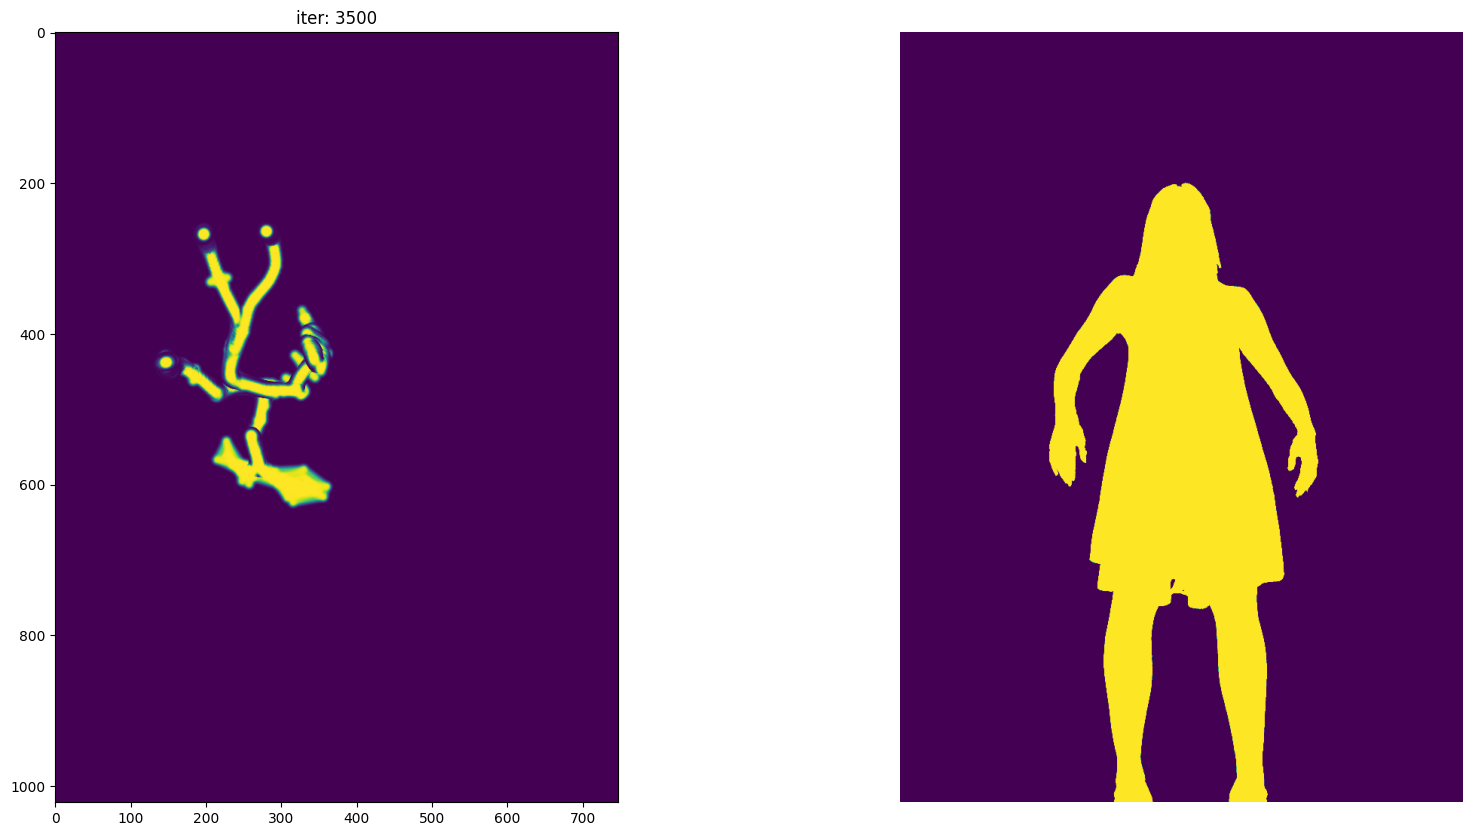

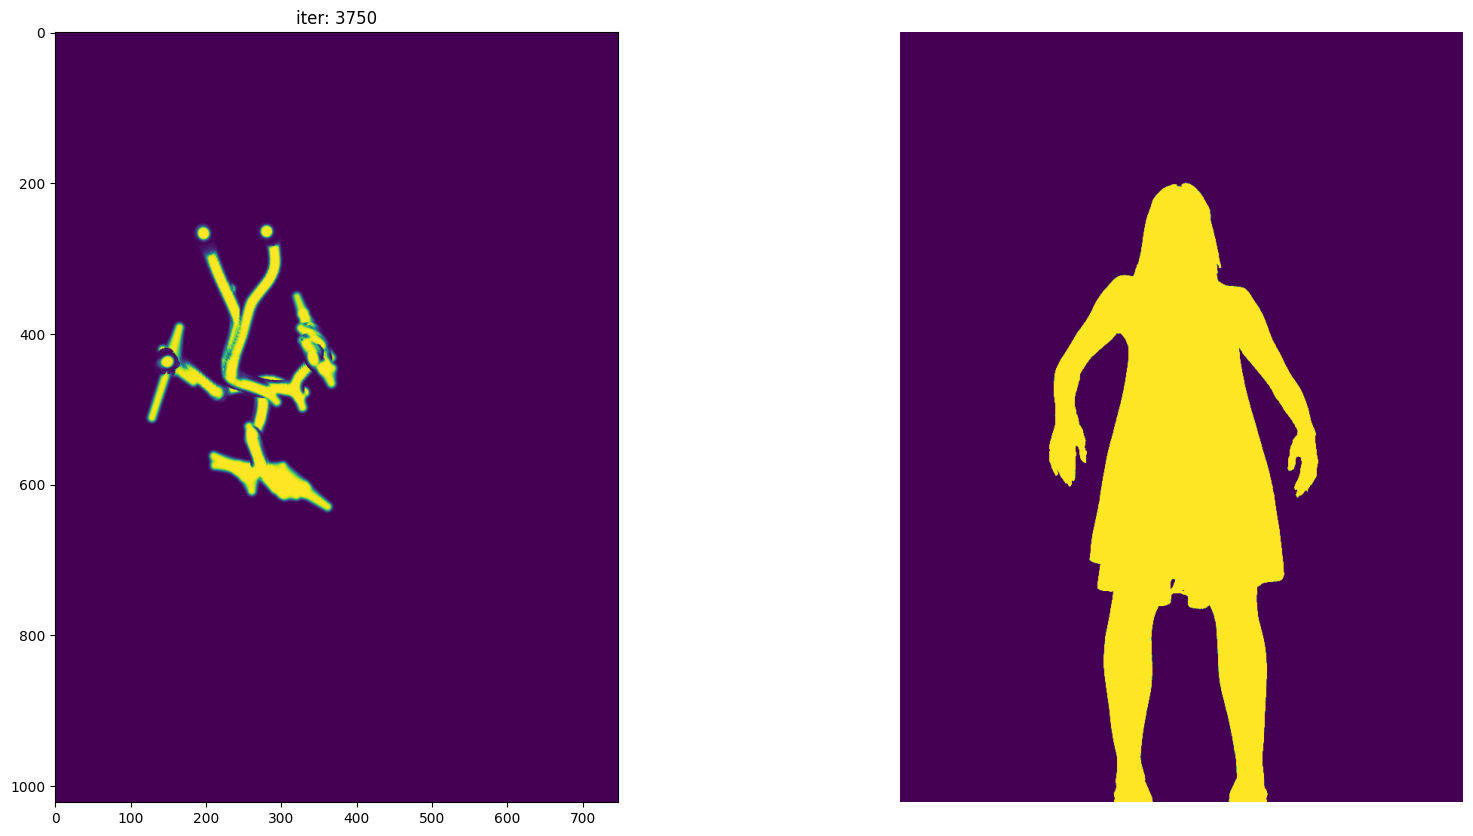

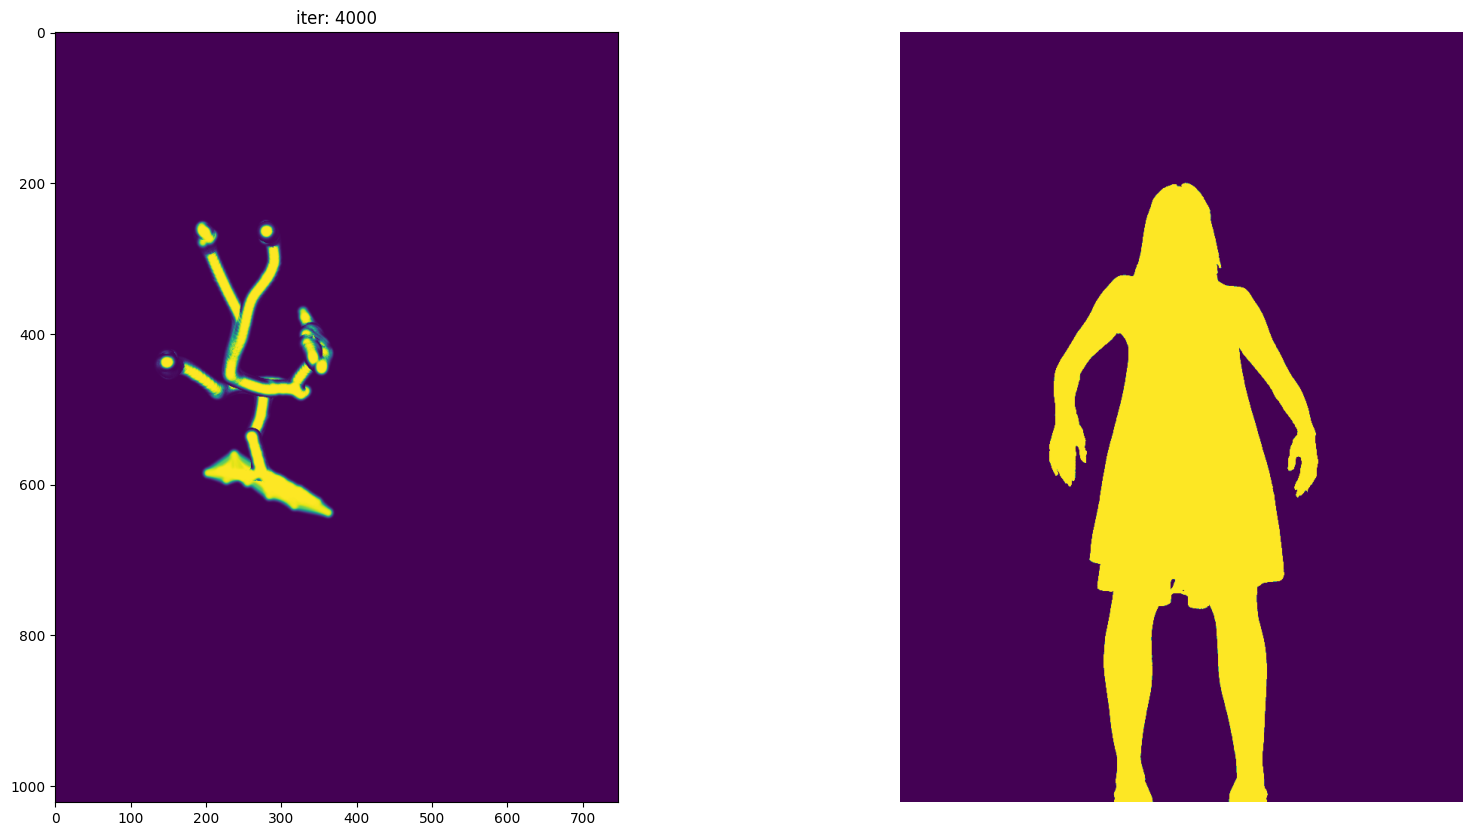

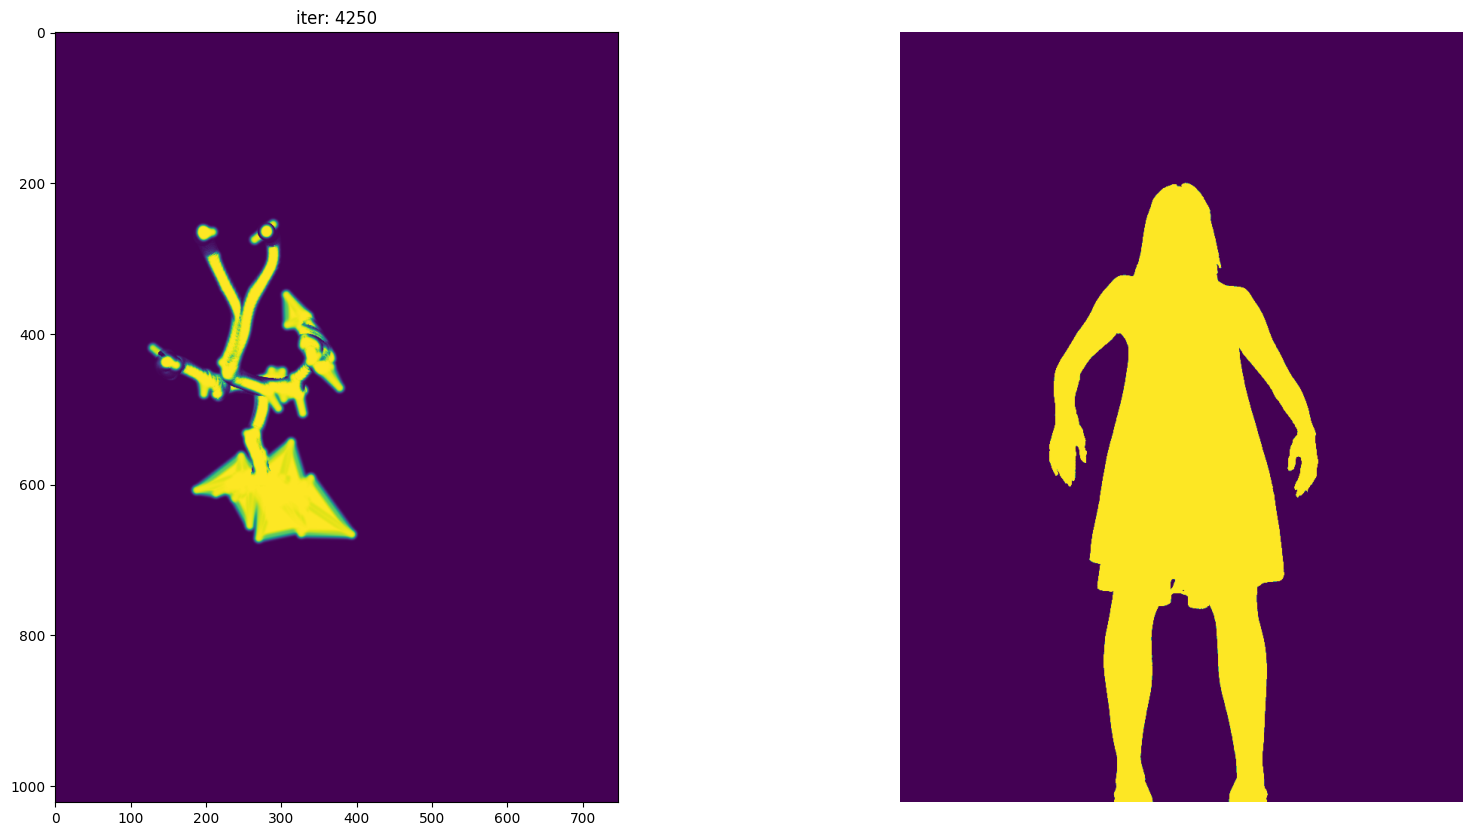

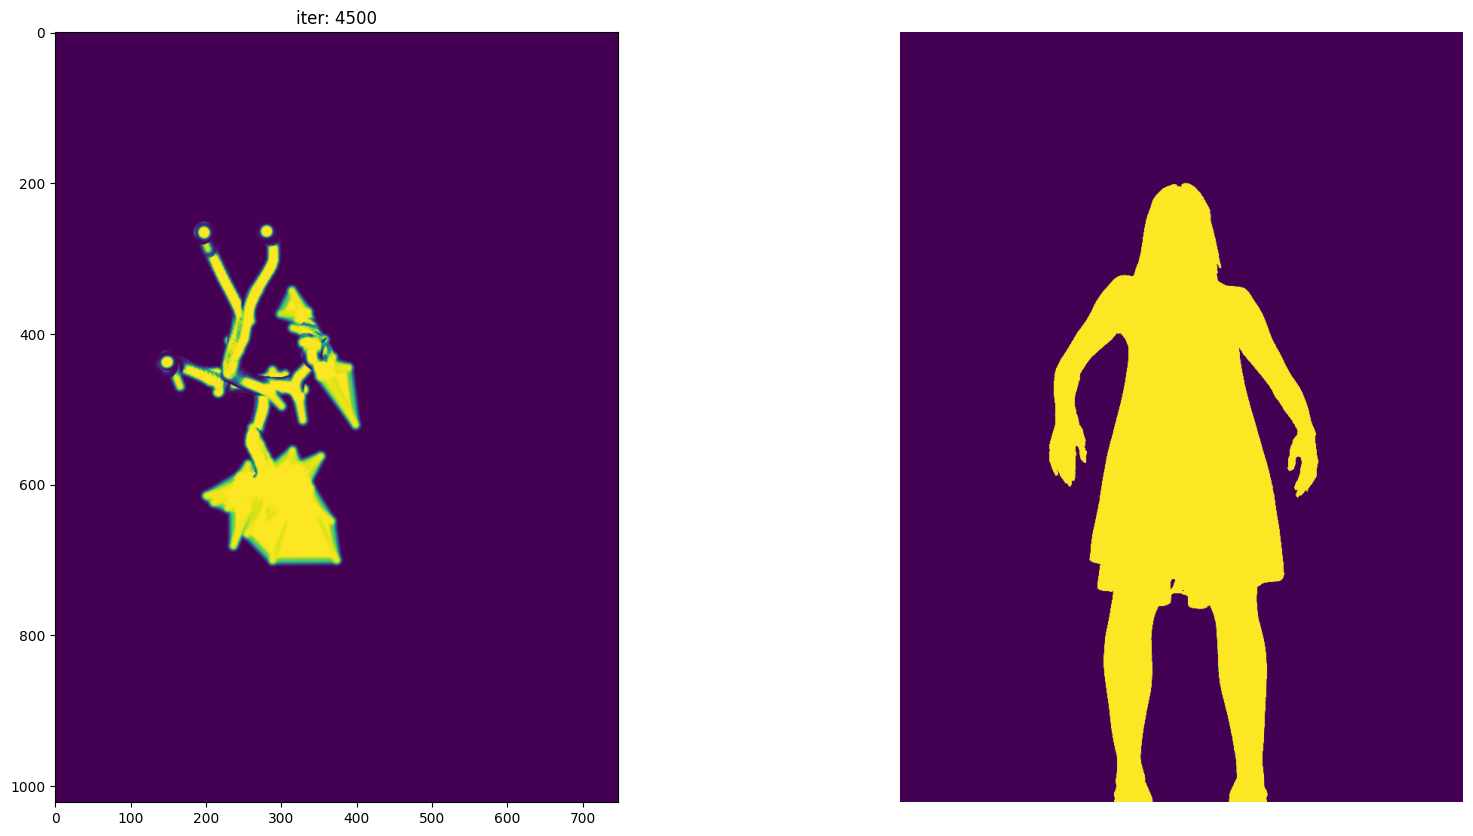

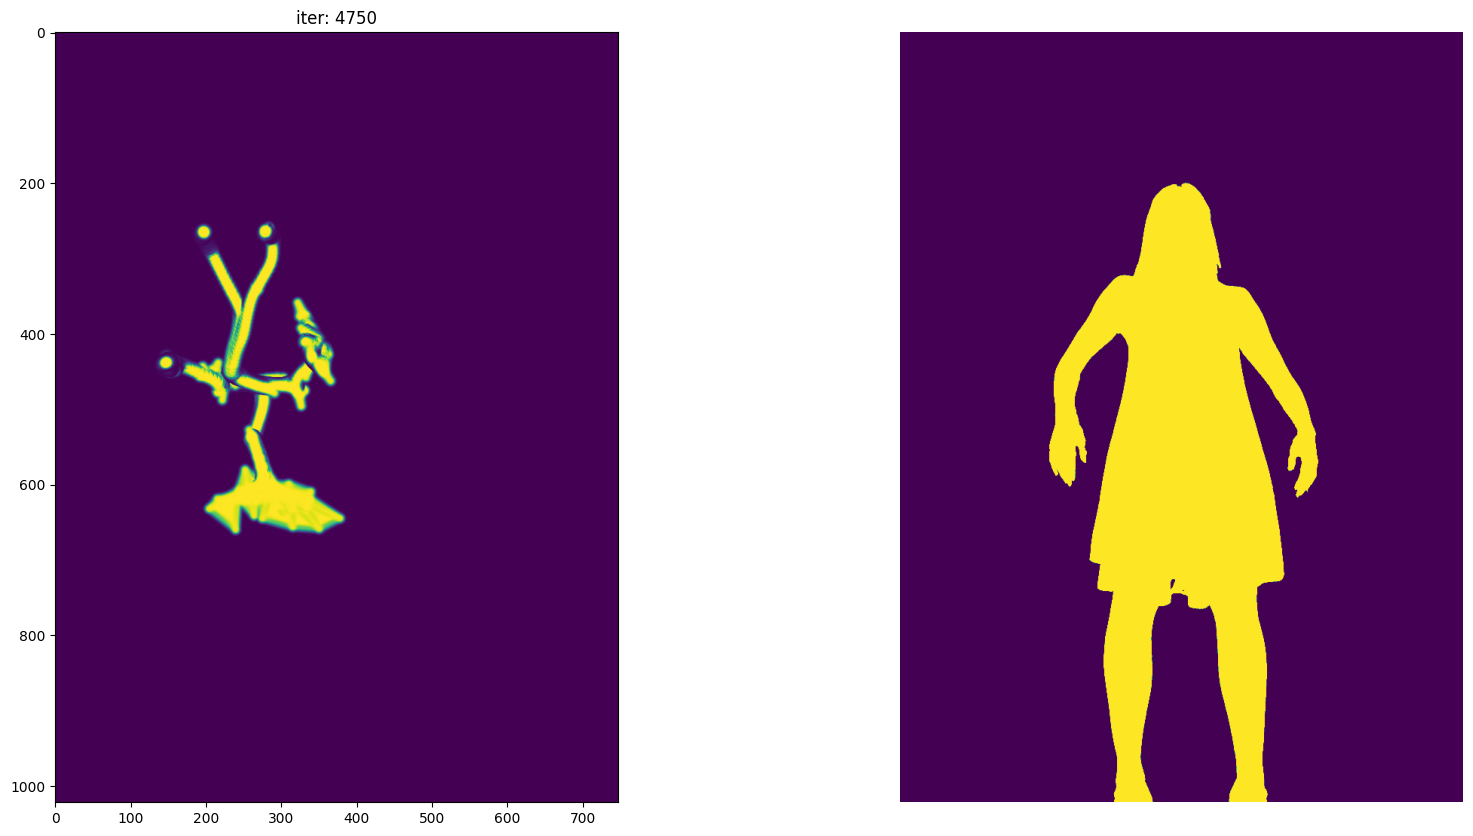

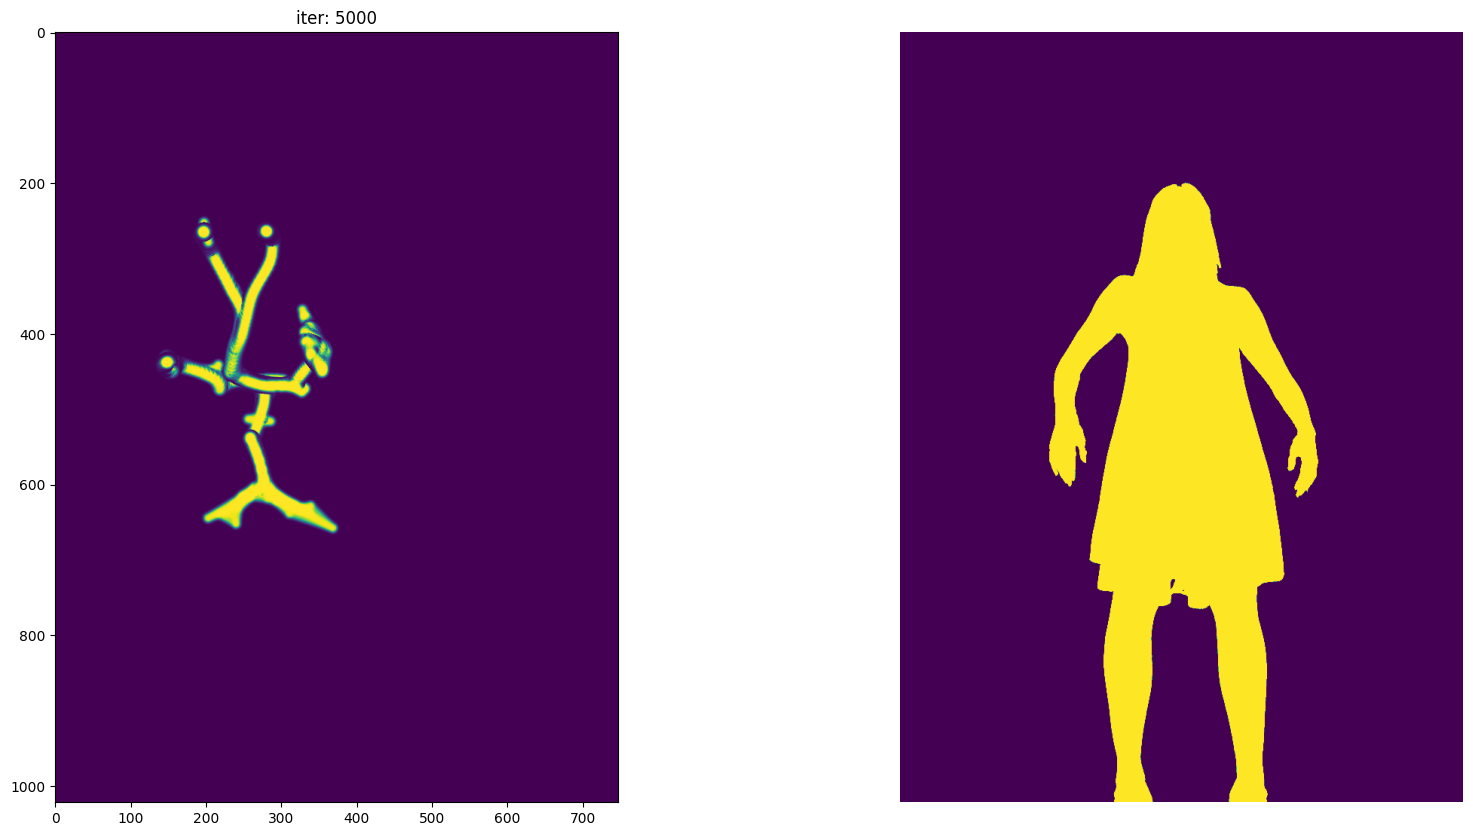

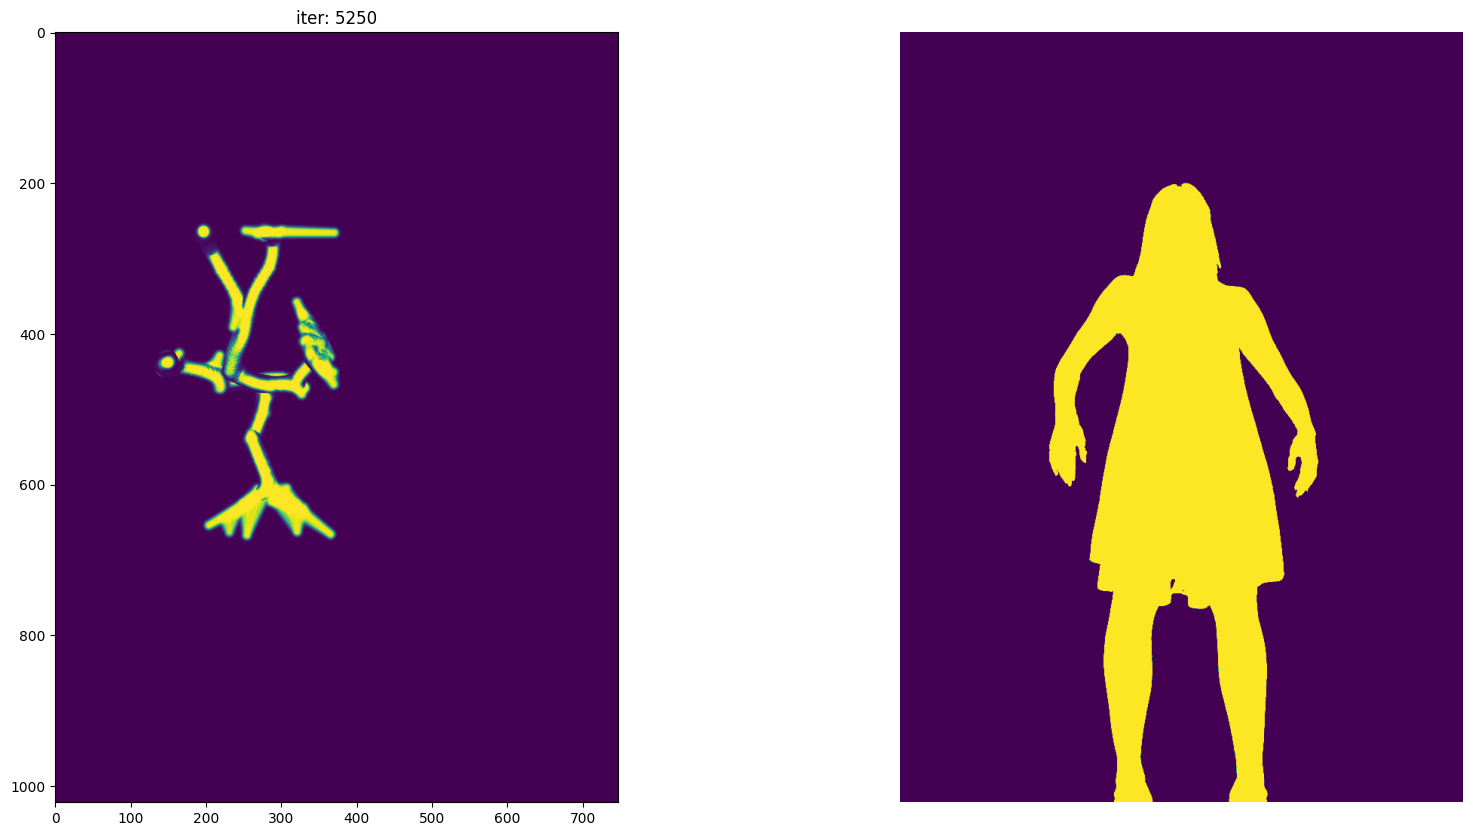

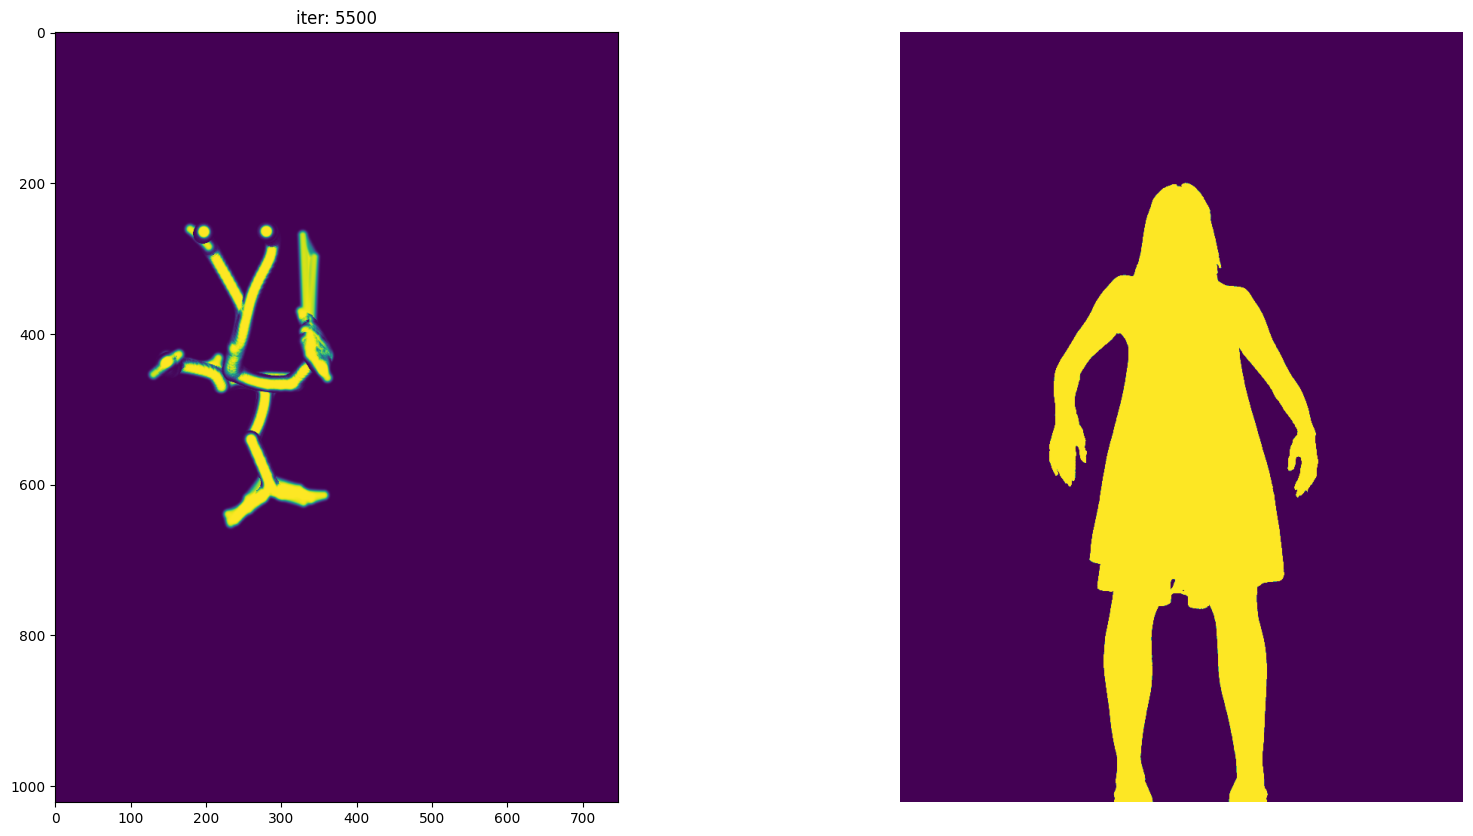

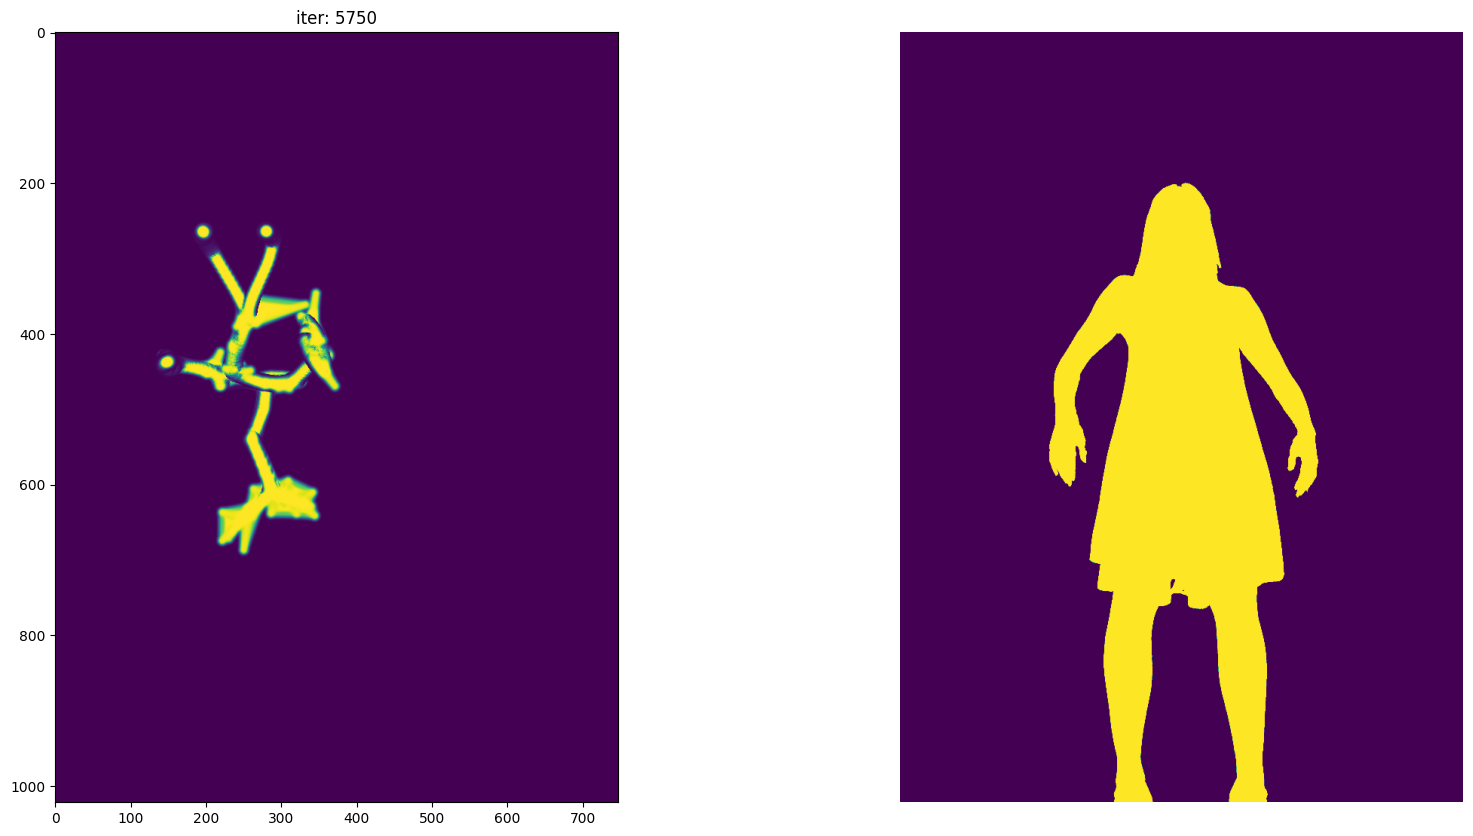

In [ ]:
loop = tqdm(range(Niter))
lights = AmbientLights(device=device)
num_views = len(imgs_paths)

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # Add per vertex colors to texture the mesh
    # new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb)

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Compute the average silhouette loss over two random views, as the average
    # squared L2 distance between the predicted silhouette and the target
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=cameras[j], lights=lights)
        # images_predicted = renderer_textured(new_src_mesh, cameras=cameras[j], lights=lights)

        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silouhettes[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration
        # print(predicted_silhouette.shape, target_sillouhettes[j].shape)

        # Squared L2 distance between the predicted RGB image and the target
        # image from the dataset
        # predicted_rgb = images_predicted[..., 2]
        # # print(predicted_rgb.shape, target_imgs[j].shape)
        # loss_rgb = ((predicted_rgb - target_imgs[j]) ** 2).mean()
        # loss["rgb"] += loss_rgb / num_views_per_iteration

    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))


    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
                             target_image=target_silouhettes[1].squeeze(), renderer=renderer_silhouette)

    # Optimization step
    sum_loss.backward()
    optimizer.step()

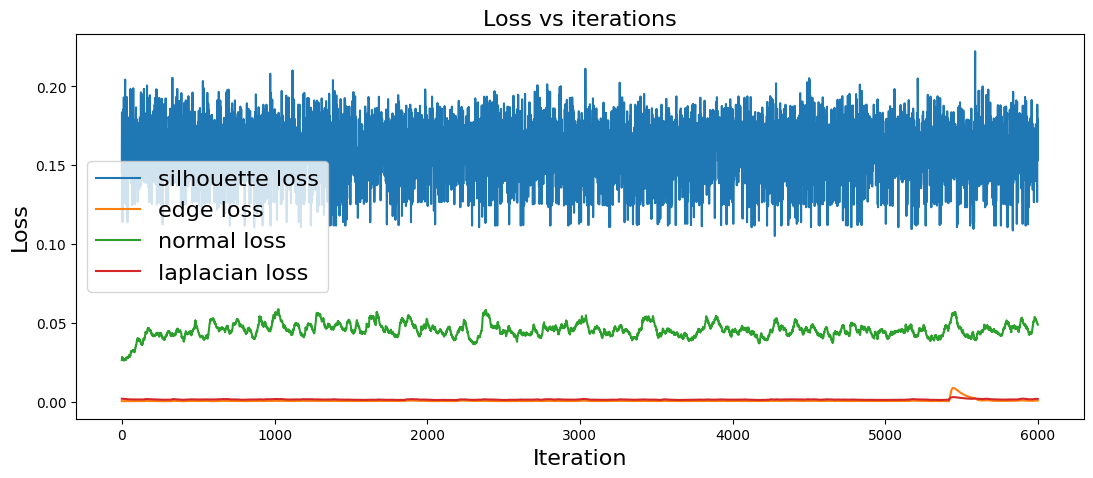

In [ ]:
plot_losses(losses)

## Saving the results

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)
scale = 10
# Scale normalize back to the original target size
final_verts = final_verts * scale # + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'BaseMesh_4_6000.obj')
save_obj(final_obj, final_verts, final_faces)

In [ ]:
# Visualization of the final predicted mesh object
plot_mesh(Meshes(verts=[final_verts.detach()], faces=[final_faces.detach()]))